# Import and Function Define

In [ ]:
from enum import Enum, auto
import datetime
import argparse
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from scipy.linalg import sqrtm
from scipy.stats import norm
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls drive

MyDrive  Shareddrives


In [ ]:
!ls drive/MyDrive/datascience/GAN

310833003_HW1.ipynb	      310833003_HW3_Fashion-Mnist.ipynb  Dog.ipynb
310833003_HW2.ipynb	      after_4_bis
310833003_HW3_Cifar-10.ipynb  DogFaceNet_Dataset_224_1.zip


In [ ]:
transform_method = transforms.Compose([transforms.Resize([64, 64]),
                                       transforms.ToTensor()])


class DogSet(Dataset):
    def __init__(self, root, transform):
        self.images = []

        print('Read images...')
        for dir_path, dir_names, file_names in tqdm(os.walk(root)):
          for file_name in file_names:
              self.images.append(transform(Image.open(os.path.join(dir_path, file_name))))
        print(f'Read {len(self.images)} images!')
  
    def __len__(self):
        return len(self.images)
  
    def __getitem__(self, idx):
        return self.images[idx]


def get_dataloader(root):
    train_loader = torch.utils.data.DataLoader(
                    DogSet(
                        root=root,
                        transform=transform_method),
                    batch_size=32,
                    shuffle=True)
    
    return train_loader

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, input_channel=1):
        super(Generator, self).__init__()

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 256 * 16 * 16),
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2),  # 16 -> 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2),  # 16 -> 31
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, input_channel, kernel_size=4, stride=2, padding=0),  # 31 -> 64
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, 16, 16)
        img = self.conv_blocks(out)
        
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channel):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=5, stride=2, padding=2),  # 64 -> 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # 32 -> 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
        )

        self.last_layer = nn.Sequential(
            nn.Linear(128 * 16 * 16, 1), 
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        out = self.last_layer(out)

        return out

In [ ]:
def epoch_step(config):
    dataloader = config['train_dataloader']
    config['generator'].train()
    config['discriminator'].train()
    
    epoch_G_losses = []
    epoch_D_losses = []

    for real_images in tqdm(dataloader):
        real_images = Variable(real_images).to(config['device'])

        # Adversarial ground truths
        valid = Variable(torch.Tensor(real_images.size(0), 1).fill_(1.0), requires_grad=False).to(config['device'])
        fake = Variable(torch.Tensor(real_images.size(0), 1).fill_(0.0), requires_grad=False).to(config['device'])
        
        # Sample noise as generator input
        z = Variable(torch.Tensor(np.random.normal(0, 1, (real_images.shape[0], config['latent_dim'])))).to(config['device'])

        # -----------------
        #  Train Generator
        # -----------------
        config['optimizer_G'].zero_grad()

        generated_images = config['generator'](z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = config['adversarial_loss'](config['discriminator'](generated_images), valid)

        g_loss.backward()
        config['optimizer_G'].step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        config['optimizer_D'].zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = config['adversarial_loss'](config['discriminator'](real_images), valid)
        fake_loss = config['adversarial_loss'](config['discriminator'](generated_images.detach()), fake)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        config['optimizer_D'].step()

        epoch_G_losses.append(g_loss.item())
        epoch_D_losses.append(d_loss.item())

    return np.mean(epoch_G_losses), np.mean(epoch_D_losses)

In [ ]:
def plot_images(config, cols=4, rows=4, z=None):
    # Sample noise as generator input
    if z is None:
        z = Variable(torch.Tensor(np.random.normal(0, 1, (cols * rows, config['latent_dim'])))).to(config['device'])

    generated_images = config['generator'](z)
    generated_images = generated_images.detach().cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)
    
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(generated_images[i-1], cmap='gray', interpolation='nearest')
    plt.suptitle('generated images', fontsize=20)
    plt.show()

In [ ]:
def run(config):
    # ----------
    # Training
    # ----------
    print(f'--- TRAINING ---')

    z = Variable(torch.Tensor(np.random.normal(0, 1, (16, config['latent_dim'])))).to(config['device'])

    total_train_loss = []
    start_time = datetime.datetime.now()

    print(f'init generator')
    plot_images(config, z=z)
    for epoch in range(config['max_epochs']):
        mean_G_loss, mean_D_loss = epoch_step(config)

        datetime_format = str(datetime.datetime.now() - start_time).split('.')[0]
        print(f'[{epoch+1}/{config["max_epochs"]}] total times: {datetime_format}, ' \
              f'G loss: {mean_G_loss:.4f}, D loss: {mean_D_loss:.4f}')
        total_train_loss.append([mean_G_loss, mean_D_loss])

        if (epoch + 1) % 5 == 0:
            print(f'epoch {epoch + 1} generator')
            plot_images(config, z=z)
    total_train_loss = np.array(total_train_loss)

    # ---------
    # Returns
    # ---------
    results = {
        'total_train_loss': {
            'G': total_train_loss[:, 0],
            'D': total_train_loss[:, 1]
        },
    }

    return results

# Training

In [ ]:
def get_config():
    train_dataloader = get_dataloader(root='./drive/MyDrive/datascience/GAN/after_4_bis')  # change to your dogset path

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    latent_dim = 100
    
    generator = Generator(latent_dim=100, input_channel=3).to(device)
    discriminator = Discriminator(input_channel=3).to(device)

    adversarial_loss = torch.nn.BCELoss() 

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0005)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

    max_epochs = 100

    config = {
        'train_dataloader': train_dataloader,
        'latent_dim': latent_dim,
        'device': device,
        'generator': generator,
        'discriminator': discriminator,
        'adversarial_loss': adversarial_loss,
        'optimizer_G': optimizer_G,
        'optimizer_D': optimizer_D,
        'max_epochs': max_epochs,
    }

    return config

In [ ]:
config = get_config()
config

Read images...


1394it [29:15,  1.26s/it]


Read 8363 images!


{'adversarial_loss': BCELoss(),
 'device': device(type='cuda'),
 'discriminator': Discriminator(
   (model): Sequential(
     (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.01)
     (3): Dropout2d(p=0.3, inplace=False)
     (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
     (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): LeakyReLU(negative_slope=0.01)
     (7): Dropout2d(p=0.3, inplace=False)
   )
   (last_layer): Sequential(
     (0): Linear(in_features=32768, out_features=1, bias=True)
     (1): Sigmoid()
   )
 ),
 'generator': Generator(
   (l1): Sequential(
     (0): Linear(in_features=100, out_features=65536, bias=True)
   )
   (conv_blocks): Sequential(
     (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (1): LeakyRe

In [ ]:
results = run(config)

Output hidden; open in https://colab.research.google.com to view.

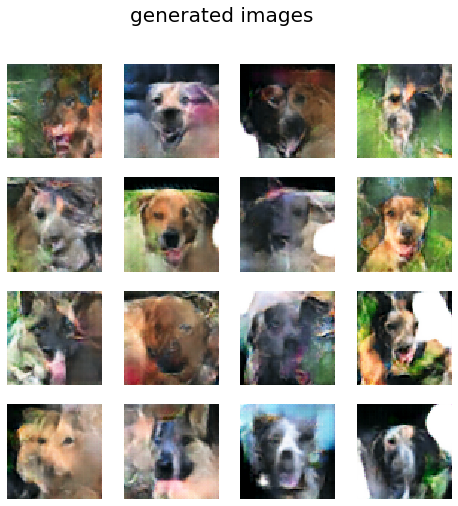

In [ ]:
plot_images(config)

In [ ]:
results

{'total_train_loss': {'D': array([0.43923759, 0.42064885, 0.29193426, 0.38482586, 0.48085559,
         0.47980495, 0.59980821, 0.63531508, 0.71040974, 0.82049632,
         0.87852171, 0.9557865 , 0.97973902, 0.96610475, 1.05384874,
         0.99447758, 1.05242664, 1.00682567, 1.07434277, 1.06623605,
         1.06756747, 1.01532342, 0.99181599, 1.06972379, 1.06676789,
         1.01989233, 1.05096941, 1.08784283, 1.0699687 , 1.11599131,
         1.12354007, 1.06711464, 1.11756288, 1.09525794, 1.13777856,
         1.08744777, 1.09062884, 1.04239003, 1.07759136, 1.07995634,
         1.06248261, 1.06710741, 1.0728431 , 1.05697757, 1.0933014 ,
         1.05475923, 1.07118462, 1.05830267, 1.09303962, 1.0812637 ,
         1.10771876, 1.08665253, 1.06009789, 1.08229455, 1.11544803,
         1.11391854, 1.11669362, 1.09940807, 1.11162265, 1.10406881,
         1.11576143, 1.11423109, 1.11751257, 1.11876585, 1.11278379,
         1.08651479, 1.10916623, 1.1255961 , 1.09615394, 1.10789668,
         

In [ ]:
print(results.keys())

dict_keys(['total_train_loss'])


In [ ]:
c = np.arange(100)
c

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
results.keys()

dict_keys(['total_train_loss'])

In [ ]:
results['total_train_loss']['G']

array([2.78791498, 3.35336396, 3.81798475, 3.62931169, 3.41680483,
       3.5109979 , 2.93308553, 2.79330713, 2.56480302, 2.78064947,
       2.66541998, 2.2330228 , 2.27687921, 2.36290505, 2.32243619,
       2.21275118, 1.94337694, 2.05445371, 1.98906493, 1.9332764 ,
       1.81508051, 1.94461081, 1.96499535, 1.868478  , 1.81438994,
       1.78591615, 1.71863451, 1.71270419, 1.69727179, 1.62397432,
       1.6122833 , 1.60655048, 1.50384811, 1.50704265, 1.47394293,
       1.4977968 , 1.4843849 , 1.5085096 , 1.50729962, 1.48526022,
       1.48619027, 1.46157634, 1.45793429, 1.48572321, 1.48000854,
       1.44693116, 1.46005939, 1.43883651, 1.41856154, 1.38371972,
       1.38903662, 1.39927003, 1.41797573, 1.35340947, 1.31549462,
       1.31188711, 1.30854905, 1.35021333, 1.30720101, 1.28707162,
       1.25520673, 1.28288056, 1.28411761, 1.31644806, 1.26874463,
       1.27454512, 1.27047081, 1.26013707, 1.28624423, 1.26899624,
       1.29211847, 1.2607999 , 1.2540683 , 1.24453989, 1.28566

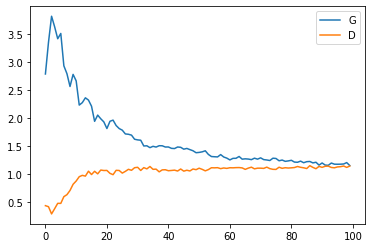

In [ ]:
plt.plot(list(c),results['total_train_loss']['G'])
plt.plot(list(c),results['total_train_loss']['D'])
plt.legend(['G','D'])
plt.show()